# ERC Risk Premia Portfolio Backtest

In this notebook we backtest a more advanced risk parity long-only portfolio of ETFs.

Review the basic riskpremia notebook in this directory first.

In [250]:
import os
import sys
import importlib
from itertools import repeat
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import ffn

%matplotlib inline

In [251]:
# Ensure the notebook can find local modules by appending the parent directory to the system path
# Requires a 'donotdelete.env' file is in the workspace root so location can be detected
from dotenv import find_dotenv
sys.path.append(os.path.dirname(find_dotenv('donotdelete.env')))

# Import local modules with hot reload
import alphasim.backtest as bt
importlib.reload(bt)
from alphasim.backtest import backtest

import alphasim.stats as ass
importlib.reload(ass)
from alphasim.stats import calc_stats, calc_log_returns, calc_rolling_ann_vola

In [252]:
tickers = ['VTI', 'TLT', 'GLD']
ticker_n = len(tickers)
price_df = pdr.get_data_yahoo(tickers, start='2000-01-01').dropna()
price_df = price_df['Adj Close']
display(price_df)

Symbols,VTI,TLT,GLD
Date,,,
2004-11-18,41.046684,50.798920,44.380001
2004-11-19,40.548500,50.393528,44.779999
2004-11-22,40.815384,50.656166,44.950001
2004-11-23,40.829632,50.719002,44.750000
2004-11-24,41.064480,50.719002,45.049999
...,...,...,...
2022-10-03,184.029999,103.830002,158.429993
2022-10-04,189.940002,103.540001,160.699997
2022-10-05,189.580002,102.550003,159.809998


## ERC Weights

Define weights based on the rolling co-variance and the equal risk contribution (ERC) algorithm.

In [253]:
# Sensible EWMA alphas
ewma_vol_alpha = 1.-0.94
ewma_cov_alpha = 1.-0.975

# Calc required time series
ret_df = np.log(price_df/price_df.shift(1)).dropna()
cumret_df = ret_df.cumsum()
vola_df = ret_df.ewm(alpha=ewma_vol_alpha, adjust=False).std() * np.sqrt(252)
cov_df = ret_df.ewm(alpha=ewma_cov_alpha, adjust=False).cov().dropna()
cov_mat = cov_df.groupby('Date').apply(lambda x: x.values)

In [254]:
# Function to calculate ERC weights for each period
def calc_erc_weight(initial_weights, cov_mat, b):
    n = len(initial_weights)
    try:
        w = ffn.core._erc_weights_ccd(initial_weights, cov=cov_mat, b=b, maximum_iterations=1000, tolerance=1e-8)
    except ValueError:
        w = np.full(n, np.NaN)
    return w

In [255]:
# Define our risk budget as equal risk
risk_budget = np.full(ticker_n, 1/ticker_n)

# Get ERC weights
weight_df = ret_df[:-1].copy()
weight_df[:] = [calc_erc_weight(x, y, z) for x, y, z in zip(
    weight_df.shift(1).values, cov_mat, repeat(risk_budget))]
weight_df = weight_df.dropna()
display(weight_df)

Symbols,VTI,TLT,GLD
Date,,,
2004-11-22,0.182859,0.269362,0.547779
2004-11-23,0.140540,0.286674,0.572786
2004-11-24,0.141150,0.286190,0.572660
2004-11-26,0.185779,0.250525,0.563696
2004-11-29,0.215503,0.298856,0.485641
...,...,...,...
2022-09-30,0.277624,0.316092,0.406284
2022-10-03,0.268306,0.329628,0.402066
2022-10-04,0.269468,0.329009,0.401523


In [256]:
price_df = price_df.align(weight_df, axis=0, join='inner')[0]
display(price_df)

Symbols,VTI,TLT,GLD
Date,,,
2004-11-22,40.815384,50.656166,44.950001
2004-11-23,40.829632,50.719002,44.750000
2004-11-24,41.064480,50.719002,45.049999
2004-11-26,41.064480,50.387848,45.290001
2004-11-29,40.975525,49.851112,45.400002
...,...,...,...
2022-09-30,179.470001,102.206001,154.669998
2022-10-03,184.029999,103.830002,158.429993
2022-10-04,189.940002,103.540001,160.699997


In [257]:
def fixed_min_commission(trade_price, trade_size):
    return 10

result_df = backtest(
    prices=price_df, 
    weights=weight_df, 
    trade_buffer=0.04, 
    do_limit_trade_size=False, 
    commission_func=fixed_min_commission,
    initial_capital=10000,
    do_reinvest=True)

display(result_df)

price        equity do_trade adj_target_weight  \
Date       Symbols                                                        
2004-11-22 VTI       40.815384           0.0      1.0          0.182859   
           TLT       50.656166           0.0      1.0          0.269362   
           GLD       44.950001           0.0      1.0          0.547779   
           cash            1.0       10000.0      0.0               1.0   
2004-11-23 VTI       40.829632   1829.227341      1.0           0.14054   
...                        ...           ...      ...               ...   
2022-10-05 cash            1.0    478.309556      0.0          0.014187   
2022-10-06 VTI      187.770004   8876.485014      0.0          0.264532   
           TLT      101.980003  10489.291184      0.0          0.312596   
           GLD      159.630005  13711.340193      0.0          0.408618   
           cash            1.0    478.309556      0.0          0.014254   

                   adj_delta_weight  trade_value  trade_size commission  \
Date       Symbols                                                        
2004-11-22 VTI             0.182859  1828.589014   44.801465       10.0   
           TLT             0.269362  2693.621108   53.174595       10.0   
           GLD             0.547779  5477.789878  121.864066       10.0   
           cash                 0.0          0.0         0.0        0.0   
2004-11-23 VTI            -0.043309  -430.912447  -10.553915       10.0   
...                             ...          ...         ...        ...   
2022-10-05 cash                 0.0          0.0         0.0        0.0   
2022-10-06 VTI                  0.0          0.0         0.0        0.0   
           TLT                  0.0          0.0         0.0        0.0   
           GLD                  0.0          0.0         0.0        0.0   
           cash                 0.0          0.0         0.0        0.0   

                   end_portfolio  
Date       Symbols                
2004-11-22 VTI         44.801465  
           TLT         53.174595  
           GLD        121.864066  
           cash            -30.0  
2004-11-23 VTI         34.247551  
...                          ...  
2022-10-05 cash       478.309556  
2022-10-06 VTI         47.273179  
           TLT        102.856353  
           GLD         85.894505  
           cash       478.309556  

[18000 rows x 9 columns]

In [258]:
stat_df = calc_stats(result_df.copy())
display(stat_df)

,equity
start,2004-11-22 00:00:00
end,2022-10-06 00:00:00
rf,0.0
total_return,2.355543
cagr,0.070093
max_drawdown,-0.215876
calmar,0.324692
mtd,0.024272
three_month,-0.045591
six_month,-0.146753


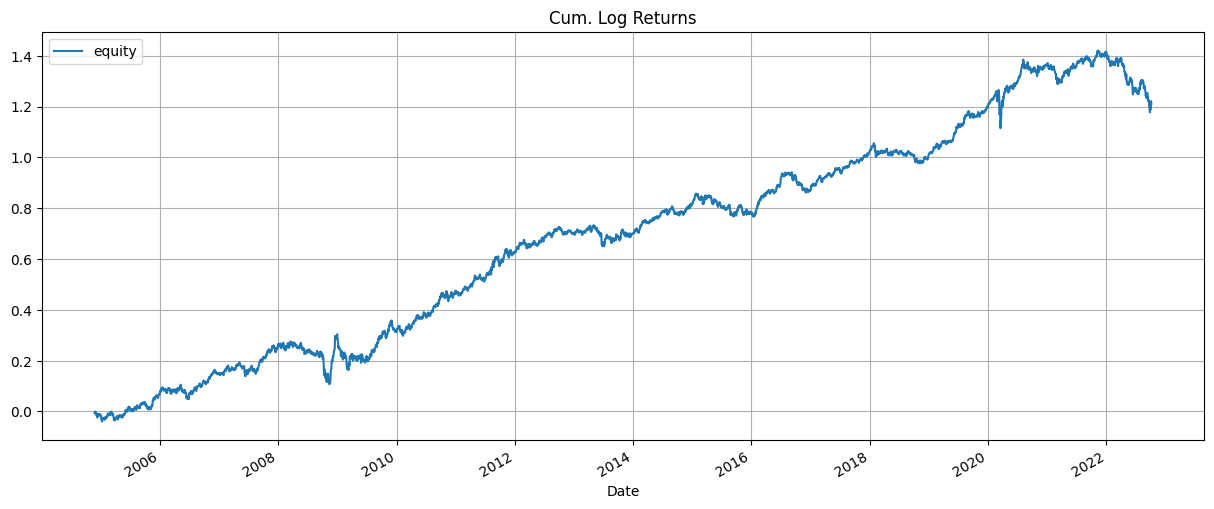

In [259]:
ax = calc_log_returns(result_df).cumsum().plot(figsize=(15, 6))
ax.grid(True)
plt.title('Cum. Log Returns')
plt.legend(loc=2)
plt.show()

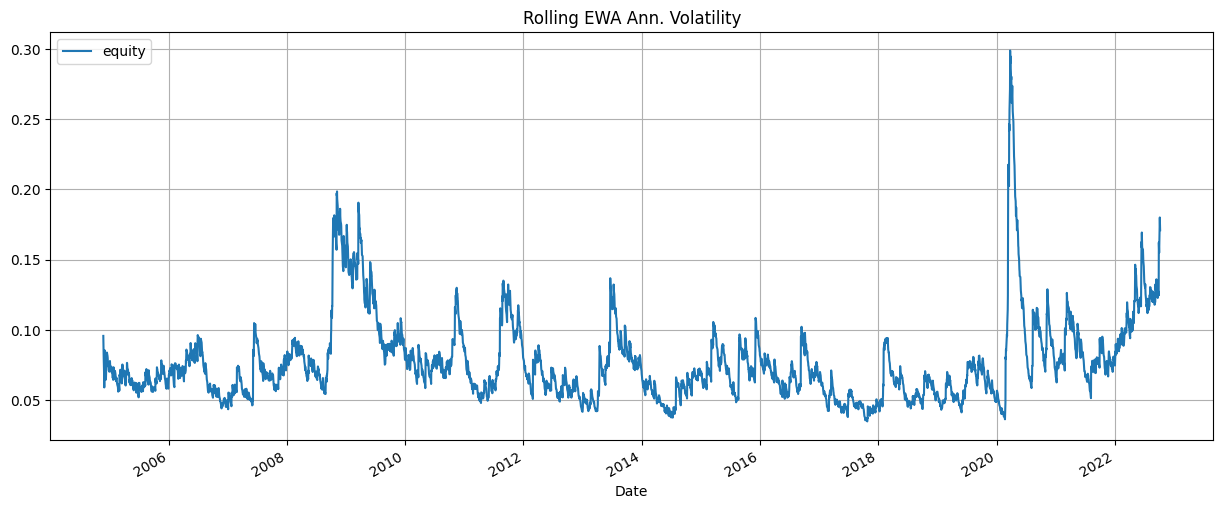

In [260]:
ax = calc_rolling_ann_vola(result_df).plot(figsize=(15, 6))
ax.grid(True)
plt.title('Rolling EWA Ann. Volatility')
plt.legend(loc=2)
plt.show()